Завдання
Використовуйте попередньо натреновану модель (MobileNetV2 або ResNet50) з TensorFlow Hub для класифікації зображень з датасету CIFAR-10.
Завантажте та передобробіть дані, адаптуйте модель, заморозивши шари та додавши новий вихідний шар.
Проведіть fine-tuning, тренуючи модель на нових даних. Оцініть точність моделі, побудуйте матрицю похибок та візуалізуйте передбачення на тестовому
наборі.

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.0869 - loss: 2.8444 - val_accuracy: 0.1520 - val_loss: 2.3660
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.1705 - loss: 2.3124 - val_accuracy: 0.2240 - val_loss: 2.1384
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3071 - loss: 2.0141 - val_accuracy: 0.3220 - val_loss: 1.9352
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3842 - loss: 1.8331 - val_accuracy: 0.4120 - val_loss: 1.7677
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.4778 - loss: 1.6472 - val_accuracy: 0.4680 - val_loss: 1.6258
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5345 - loss: 1.4859 - val_accuracy: 0.5040 - val_loss: 1.5139
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5888 - loss: 1.3229 - val_accuracy: 0.5440 - val_loss: 1.4135
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6179 - loss: 1.2456 - val_accuracy: 0.5840 - val_loss:

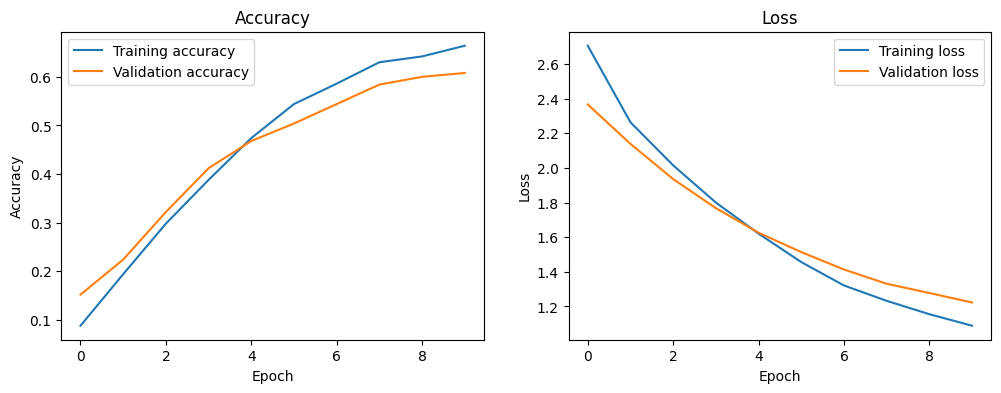

16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


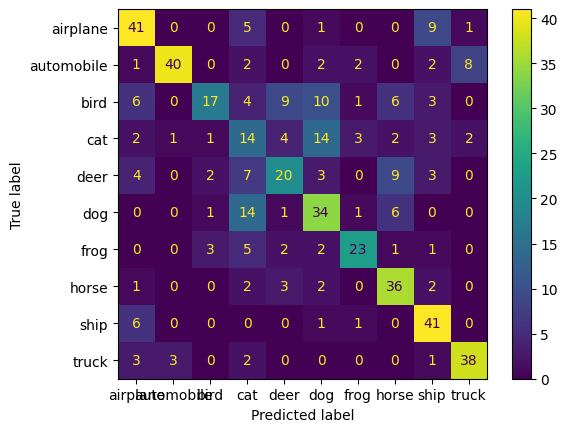

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


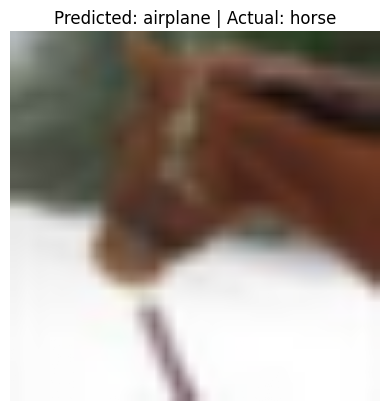

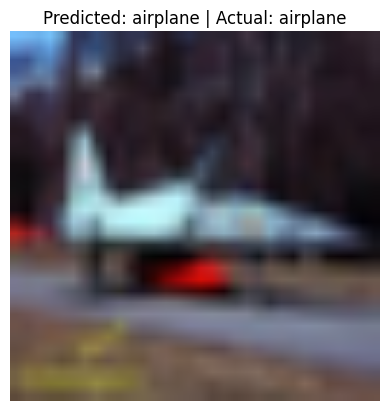

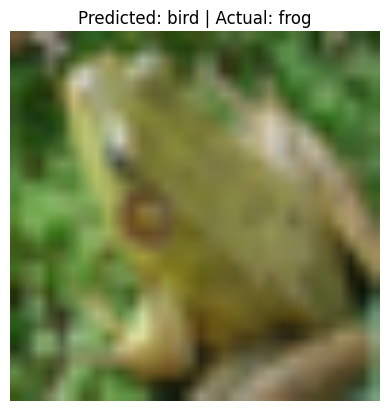

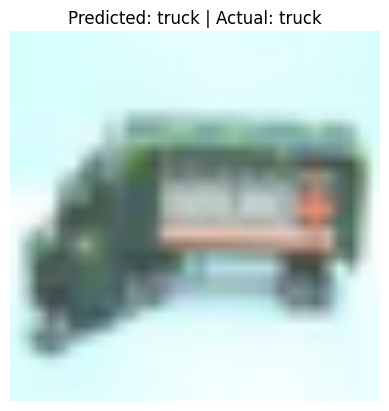

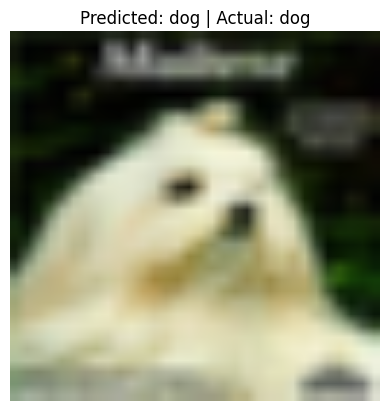

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds

# Завантаження датасету CIFAR-10
(dataset_train, dataset_test), dataset_info = tfds.load("cifar10", 
                                                        split=['train', 'test'], 
                                                        as_supervised=True, 
                                                        with_info=True)

# Функція для передобробки зображень
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Масштабування
    image = tf.cast(image, tf.float32) / 255.0  # Нормалізація
    return image, label

# Обмеження кількості даних до 500 зображень
train_data = dataset_train.take(500).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = dataset_test.take(500).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# Завантаження попередньо натренованої моделі MobileNetV2
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,  # Без верхнього шару (для передачі навчання)
                         weights='imagenet')  # Використовуємо ваги ImageNet

# Заморожуємо всі шари базової моделі
base_model.trainable = False

# Створення моделі
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')  # CIFAR-10: 10 класів
])

# Розморозка верхніх шарів для fine-tuning
fine_tune_at = len(base_model.layers) - 20  # Розморозити останні 20 шарів

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Компіляція моделі
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Навчання моделі
history = model.fit(train_data, 
                    epochs=10, 
                    validation_data=test_data)

# Оцінка точності моделі
loss, accuracy = model.evaluate(test_data)
print(f"Test accuracy: {accuracy:.2f}")

# Побудова графіків для точності та втрат
def plot_history(history):
    # Точність
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Втрати
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

# Побудова матриці похибок
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = np.argmax(model.predict(test_data), axis=-1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset_info.features['label'].names)
disp.plot(cmap='viridis')
plt.show()

# Візуалізація результатів
for images, labels in test_data.take(1):
    preds = model.predict(images)
    for i in range(5):  # Візуалізація 5 зображень
        plt.imshow(images[i].numpy())
        plt.title(f"Predicted: {dataset_info.features['label'].names[np.argmax(preds[i])]} | Actual: {dataset_info.features['label'].names[labels[i]]}")
        plt.axis('off')
        plt.show()



Ми використовували попередньо натреновану модель MobileNetV2, доступну через TensorFlow, для вирішення задачі класифікації зображень на основі набору даних CIFAR-10. Структура моделі виглядає наступним чином:

1.Базова модель (MobileNetV2):

Вхідна форма: (224, 224, 3) — це стандартний розмір зображень, який підходить для MobileNetV2.
Модель використовує попередньо натреновані ваги, взяті з ImageNet, і не включає верхній шар (тобто без класифікації).

2.Глобальний середній пулінг (GlobalAveragePooling2D):
Після того, як зображення обробляються через базову модель, використовуємо глобальний середній пулінг для зменшення розмірів виводу.

3.Повнозв’язаний шар (Dense):
Перший повнозв'язаний шар містить 128 нейронів з функцією активації relu, що забезпечує нелінійність моделі.
Використано регуляризацію через Dropout (0.2), щоб запобігти перенавчанню.

4.Фінальний шар класифікації (Dense):
Вихідний шар з 10 нейронами з функцією активації softmax для багатокласової класифікації (CIFAR-10 містить 10 класів).

Етапи адаптації моделі:
1.Завантаження попередньо натренованої моделі:
    Використали MobileNetV2 без верхнього шару, що дозволяє адаптувати модель для нової задачі класифікації.

2.Замороження базових шарів:
    Усі шари базової моделі були заморожені для запобігання їх зміні під час початкового етапу тренування.

3.Додавання нових шарів:
    Додано глобальний середній пулінг, повнозв'язаний шар з 128 нейронами і фінальний шар з 10 класами для класифікації зображень CIFAR-10.

4.Fine-Tuning:
    Для покращення точності було розморожено деякі шари базової моделі (останні 20 шарів) для подальшого донавчання.

5.Навчання моделі:
    Модель була навчена на 500 зображеннях з набору даних CIFAR-10. Для оптимізації використовувався адаптивний метод Adam з початковою швидкістю навчання 1e-4.